In [35]:
import math
import sys
import numpy as np
import re
import string
import random
from random import randint
import cv2
import os

%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plti

%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/
env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/


In [80]:
# CONSTANTS
IM_PATH = "/home/fizzer/CNN_images"
CP_PATH = "/home/fizzer/cnn_trainer/model_cps/"
SAVE_PATH = "/home/fizzer/cnn_trainer/model_save/"
# INNER:
# IM_PATH = "/home/fizzer/inner_images"
# CP_PATH = "/home/fizzer/cnn_trainer/inner/model_cps/"
# SAVE_PATH = "/home/fizzer/cnn_trainer/inner/model_save/"
NUM_LABELS = 4
CONFIDENCE_THRESHOLD = 0.01
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 7e-5
IMG_DOWNSCALE_RATIO = 0.25
VERTICAL_CROP = 80

In [37]:
# Setup ref and read files
one_hot_ref = {
    'L': np.array([1.,0.,0.]),
    'F': np.array([0.,1.,0.]),
    'R': np.array([0.,0.,1.]),
}
# Read the images from the files 
dir_contents = np.array(os.listdir(IM_PATH))
np.random.shuffle(dir_contents)
im_set = []
for im_path in dir_contents:
    spl = im_path.split('_')
    x_vel = float(spl[0])
    z_vel = float(spl[1])
    if (x_vel > 0):
        label = one_hot_ref['F']
    elif (z_vel > 0):
        label = one_hot_ref['L']
    elif (z_vel < 0):
        label = one_hot_ref['R']
    img = cv2.cvtColor(cv2.imread(f"{IM_PATH}/{im_path}"), cv2.COLOR_RGB2GRAY)
    im_set.append([label, cv2.resize(img, (0,0), fx=IMG_DOWNSCALE_RATIO, fy=IMG_DOWNSCALE_RATIO)])
# im_set = np.array(im_set, dtype=object)

In [38]:
# Create x_dataset and y_dataset
x_dataset = np.array([img[1][:] for img in im_set[:]])
y_dataset = np.array([img[0] for img in im_set[:]])
x_dataset = x_dataset/255.0
del(im_set)
# TODO: may need this x_dataset = x_dataset.reshape(len(x_dataset), len(x_dataset[0]), len(x_dataset[0][0]),-1)

(2921, 180, 320)


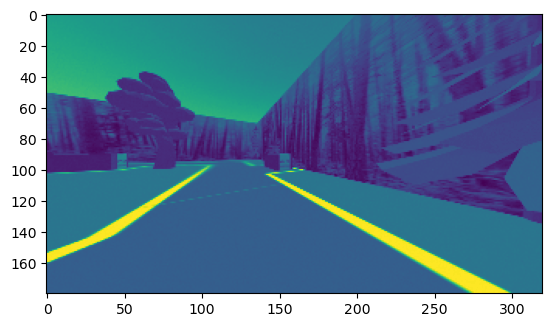

In [39]:
print(x_dataset.shape)
plt.imshow(x_dataset[0]*255.)

In [81]:
# TODO: The following was copy pasted - validate
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if (hasattr(model.layers[ix], 'kernel_initializer') and 
            hasattr(model.layers[ix], 'bias_initializer')):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [118]:
# Set up CNN
def create_model():
    conv_model = models.Sequential()
    conv_model.add(layers.Conv2D(3, (5, 5), activation='relu',
                            input_shape=(x_dataset.shape[1], x_dataset.shape[2], 1)))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(18, (3, 3), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(24, (3, 3), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Flatten())
    conv_model.add(layers.Dropout(0.5))
    conv_model.add(layers.Dense(256, activation='relu'))
    conv_model.add(layers.Dense(25, activation='relu'))
    conv_model.add(layers.Dense(3, activation='softmax'))
    conv_model.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE), metrics=['acc'])
    return conv_model

conv_model = create_model()
cp_callback = callbacks.ModelCheckpoint(filepath=CP_PATH, save_weights_only=True, verbose=1)


In [119]:
# reset_weights(conv_model)

In [120]:
# # Train CNN
# begin = 0
# block_length = len(x_dataset) // 5
# for i in range(block_length, len(x_dataset), block_length):
#     history_conv = conv_model.fit(x_dataset[begin:block_length], y_dataset[begin:block_length], 
#                                 validation_split=VALIDATION_SPLIT, 
#                                 epochs=20, 
#                                 batch_size=16)
#     x_dataset = x_dataset[block_length:]
#     y_dataset = y_dataset[block_length:]

In [121]:
# Train CNN
history_conv = conv_model.fit(x_dataset, y_dataset, 
                                 validation_split=VALIDATION_SPLIT, 
                                 epochs=60, 
                                 batch_size=16,
                                 callbacks=[cp_callback])

Epoch 1/60
144/146 [============================>.] - ETA: 0s - loss: 0.1752 - acc: 0.5972
Epoch 1: saving model to /home/fizzer/cnn_trainer/model_cps/
146/146 [==============================] - 2s 6ms/step - loss: 0.1747 - acc: 0.5993 - val_loss: 0.1575 - val_acc: 0.6769
Epoch 2/60
132/146 [==========================>...] - ETA: 0s - loss: 0.1462 - acc: 0.7003
Epoch 2: saving model to /home/fizzer/cnn_trainer/model_cps/
146/146 [==============================] - 1s 4ms/step - loss: 0.1470 - acc: 0.6969 - val_loss: 0.1511 - val_acc: 0.7026
Epoch 3/60
133/146 [==========================>...] - ETA: 0s - loss: 0.1392 - acc: 0.7204
Epoch 3: saving model to /home/fizzer/cnn_trainer/model_cps/
146/146 [==============================] - 1s 4ms/step - loss: 0.1398 - acc: 0.7188 - val_loss: 0.1402 - val_acc: 0.7128
Epoch 4/60
145/146 [============================>.] - ETA: 0s - loss: 0.1334 - acc: 0.7207
Epoch 4: saving model to /home/fizzer/cnn_trainer/model_cps/
146/146 [====================

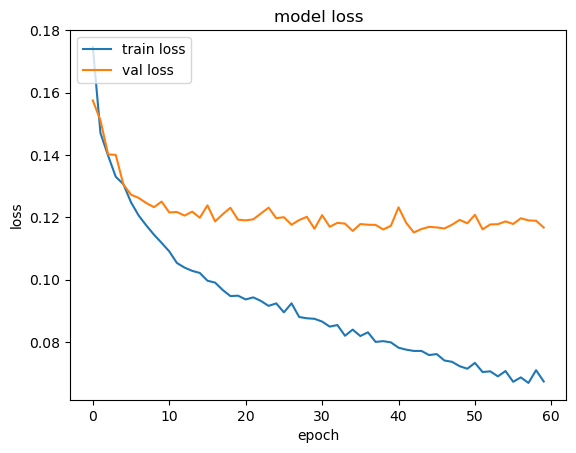

In [122]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

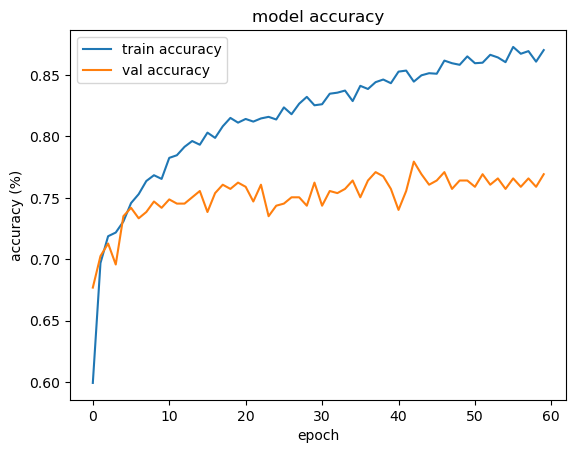

In [123]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [124]:
from sklearn.metrics import confusion_matrix

92/92 [==============================] - 0s 2ms/step


<AxesSubplot:>

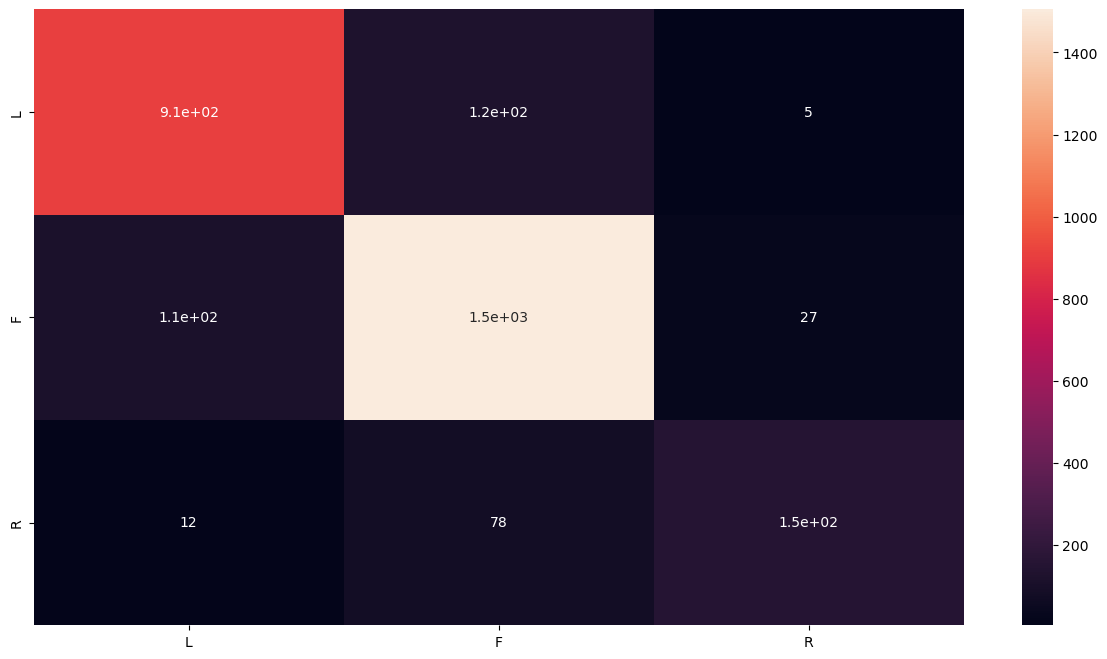

In [125]:
pred_matrix = conv_model.predict(x_dataset)

pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(y_val) for y_val in y_dataset]

conf_matrix = confusion_matrix(corr_results, pred_results)

df_cm = pd.DataFrame(conf_matrix, index = [val for i, val in enumerate(one_hot_ref) if i < 4],
                  columns = [val for i, val in enumerate(one_hot_ref) if i < 4])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)

In [126]:
conv_model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/model_save/assets


INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/model_save/assets


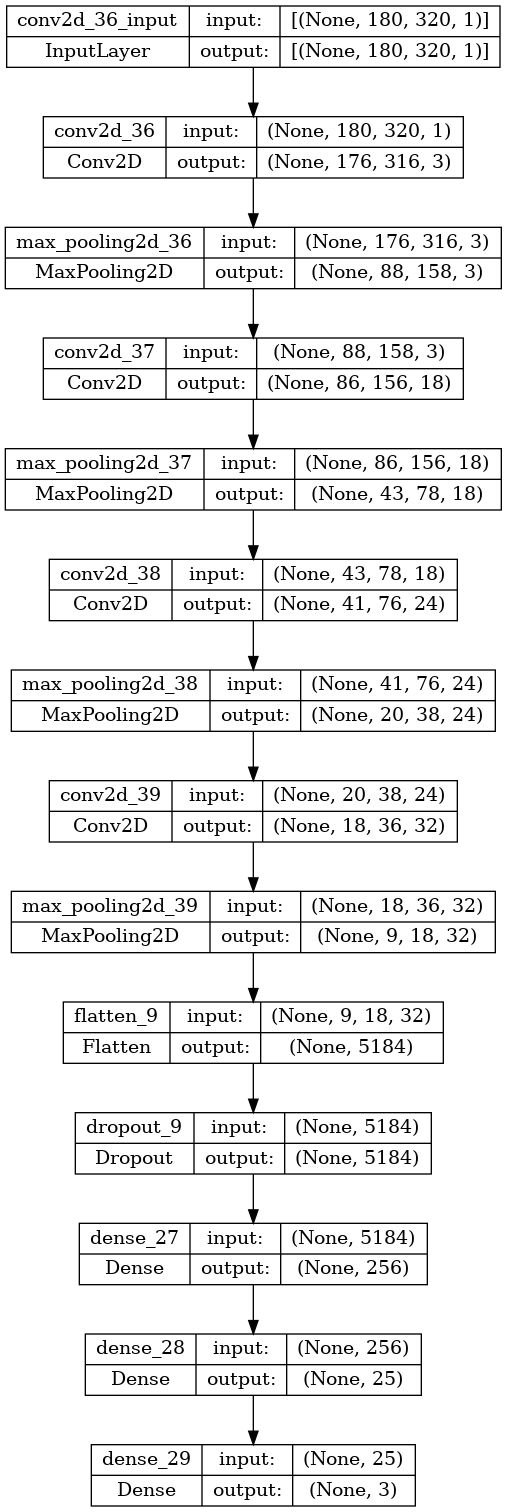

In [127]:
plot_model(conv_model, to_file='drive_model.png', show_shapes=True)